In [3]:
import pandas as pd
pd.set_option('display.max_rows', 1000)  # or 1000
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns

import pingouin as pg
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import linregress

import dabest
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Data preparation

Download data from https://zenodo.org/doi/10.5281/zenodo.10698564

In [4]:
comps = pd.read_feather('FOLDER/comps.feather')
C = pd.read_hdf('FOLDER/C.h5', 'C')
S = pd.read_hdf('FOLDER/S.h5', 'S')
behaviour = pd.read_hdf('FOLDER/behaviour.h5', 'behaviour')

In [5]:
comps.loc[~pd.isnull(comps['VeloCorrelationP']), 'VeloCorrelationP_adj'] = multipletests(comps.loc[~pd.isnull(comps['VeloCorrelationP']), 'VeloCorrelationP'].values, method='fdr_bh')[1]  # fdr_bh
comps['SpeedCell'] = (comps.VeloCorrelationP_adj<.05).astype(int)
comps.loc[(comps.VeloCorrelation<0)&(comps.SpeedCell), 'SpeedCell'] = -1
comps['SpeedCell_n'] = comps.SpeedCell==-1
comps['SpeedCell_p'] = comps.SpeedCell==True
comps['RedC'] = 'Green'
comps.loc[comps.Red==1, 'RedC'] = 'Red'
comps = comps.set_index(['ExpID', 'NeuronID'])
comps

COM_x       COM_y    Red  VeloCorrelation  \
ExpID NeuronID                                                   
100   0         231.327754  163.246358  False        -0.011470   
      1          85.803925  297.011614  False        -0.226335   
      2          81.299596  230.208318  False        -0.095840   
      3          49.978551  361.024682  False         0.215721   
      4         365.519515  321.801320  False        -0.388128   
...                    ...         ...    ...              ...   
166   918       485.109722  287.417032  False        -0.384738   
      919       391.570251  438.940664  False         0.031838   
      920       734.789844  721.921729  False        -0.427842   
      921       491.045679  562.901971  False        -0.472598   
      922       275.973672  401.703792  False        -0.490822   

                VeloCorrelationP  LickingIdx  PlaceScore  \
ExpID NeuronID                                             
100   0                 0.953807    0.192816    0.715640   
      1                 0.246801         NaN    6.173925   
      2                 0.627579         NaN    5.433429   
      3                 0.270248         NaN    4.326201   
      4                 0.041257    0.080195    8.821839   
...                          ...         ...         ...   
166   918               0.043218         NaN    4.517022   
      919               0.872229         NaN    1.759884   
      920               0.023137         NaN    5.616556   
      921               0.011099         NaN    5.598232   
      922               0.008002         NaN    5.565182   

                PlaceScoreShufflingPercentile    ComAngle       Rho  ...  \
ExpID NeuronID                                                       ...   
100   0                                  44.4  105.431908  0.003123  ...   
      1                                  82.3         NaN       NaN  ...   
      2                                  77.6   28.069369  0.013425  ...   
      3                                  71.7         NaN       NaN  ...   
      4                                  94.9         NaN       NaN  ...   
...                                       ...         ...       ...  ...   
166   918                                99.5  145.023860  0.054967  ...   
      919                                97.0  104.364162  0.222380  ...   
      920                                78.6  124.467168  0.142849  ...   
      921                                78.6  124.753290  0.119810  ...   
      922                                82.1  125.495768  1.115155  ...   

                C_onset_lickbout_initial_shuffle_neg90  \
ExpID NeuronID                                           
100   0                                          False   
      1                                          False   
      2                                          False   
      3                                          False   
      4                                          False   
...                                                ...   
166   918                                        False   
      919                                        False   
      920                                        False   
      921                                        False   
      922                                        False   

                C_onset_lickbout_initial_shuffle_neg91  \
ExpID NeuronID                                           
100   0                                          False   
      1                                          False   
      2                                          False   
      3                                          False   
      4                                          False   
...                                                ...   
166   918                                        False   
      919                                         True   
      920                                        False   

In [6]:
S_z = S.apply(lambda x: (x-x.mean())/x.std())
C_z = C.apply(lambda x: (x-x.mean())/x.std())

behaviour['VeloBin'] = np.nan
behaviour.loc[(behaviour.Velocity_ds>2)&(behaviour.Velocity_ds<30), 'VeloBin'] = (behaviour.loc[(behaviour.Velocity_ds>2)&(behaviour.Velocity_ds<30), 'Velocity_ds']/5).astype(int)*5

In [7]:
exps = [100, 103, 117, 125, 126, 127, 136, 137, 139, 140, 142, 143, 144, 148, 152, 154, 156, 163, 166]

veloBinned = []
for expID in exps:
    comps_exp = comps.loc[expID]
    comps_exp['ExpID'] = expID
    veloBinned.append(S[expID].dropna().join(behaviour.loc[expID, 'VeloBin']).groupby('VeloBin').mean(
        ).drop(['PositionBin', 'Lap'], axis=1).T.join(comps_exp.reset_index()[['ExpID', 'NeuronID', 'Red', 'VeloCorrelationP_adj', 'VeloCorrelation']]))
veloBinned = pd.concat(veloBinned)
veloBinned['maxVeloBin'] = veloBinned.iloc[:, :6].idxmax(axis=1)
veloBinned

,0.0,5.0,10.0,15.0,20.0,25.0,ExpID,NeuronID,Red,VeloCorrelationP_adj,VeloCorrelation,maxVeloBin
0,0.003817,0.006067,0.003650,0.004905,0.004878,0.000871,100,0,False,0.977643,-0.011470,5.0
1,0.000000,0.000462,0.000000,0.000000,0.000000,0.000000,100,1,False,0.372179,-0.226335,5.0
2,0.000000,0.000000,0.001621,0.000021,0.000458,0.000000,100,2,False,0.740870,-0.095840,10.0
3,0.000000,0.000000,0.001621,0.000000,0.000178,0.002998,100,3,False,0.397640,0.215721,25.0
4,0.002224,0.002066,0.000000,0.000000,0.000000,0.000000,100,4,False,0.100677,-0.388128,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
918,0.000000,0.008660,0.004630,0.000927,0.000890,0.000363,166,918,False,0.104076,-0.384738,5.0
919,0.000804,0.002180,0.001097,0.001483,0.001838,0.001464,166,919,False,0.922996,0.031838,5.0
920,0.002163,0.001277,0.002150,0.000457,0.000000,0.000000,166,920,False,0.067210,-0.427842,0.0
921,0.002518,0.000642,0.001665,0.000489,0.000000,0.000000,166,921,False,0.039354,-0.472598,0.0


# Figure 5A

(500.0, 9500.0)

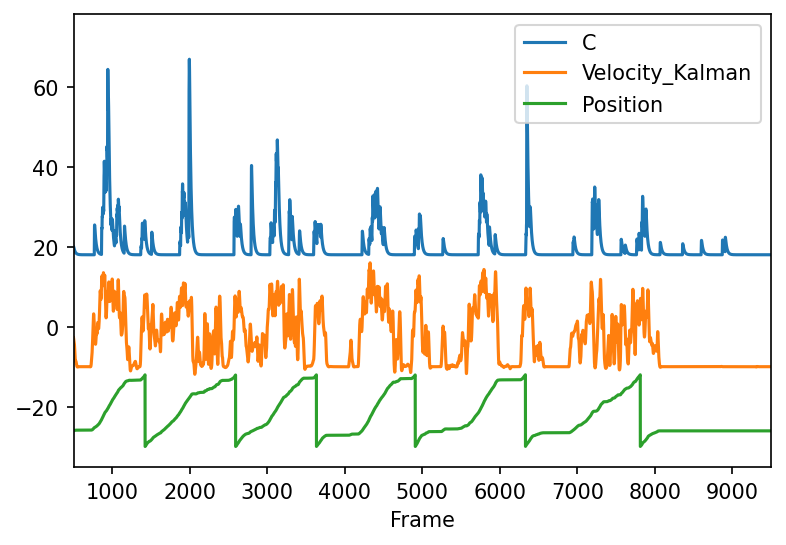

In [8]:
expID = 152
cell = 185  # 185 / 12

df_to_plot = behaviour.loc[expID]
df_to_plot['S'] = S_z[expID, cell]
df_to_plot['C'] = C_z[expID, cell]
df_to_plot['C'] = df_to_plot['C'] * 5 + 20
df_to_plot['Position'] = df_to_plot['Position'] /20 - 30
df_to_plot['Velocity_Kalman'] = df_to_plot['Velocity_Kalman'].shift(3) * 5 - 10
df_to_plot[['C', 'Velocity_Kalman', 'Position']].plot()
plt.xlim([500, 9500])


# Figure 5B

LinregressResult(slope=0.03592241782611131, intercept=-0.21781070274188932, rvalue=0.9373891188871066, pvalue=0.005757462490776083, stderr=0.00667342820082389, intercept_stderr=0.10102403627634318)


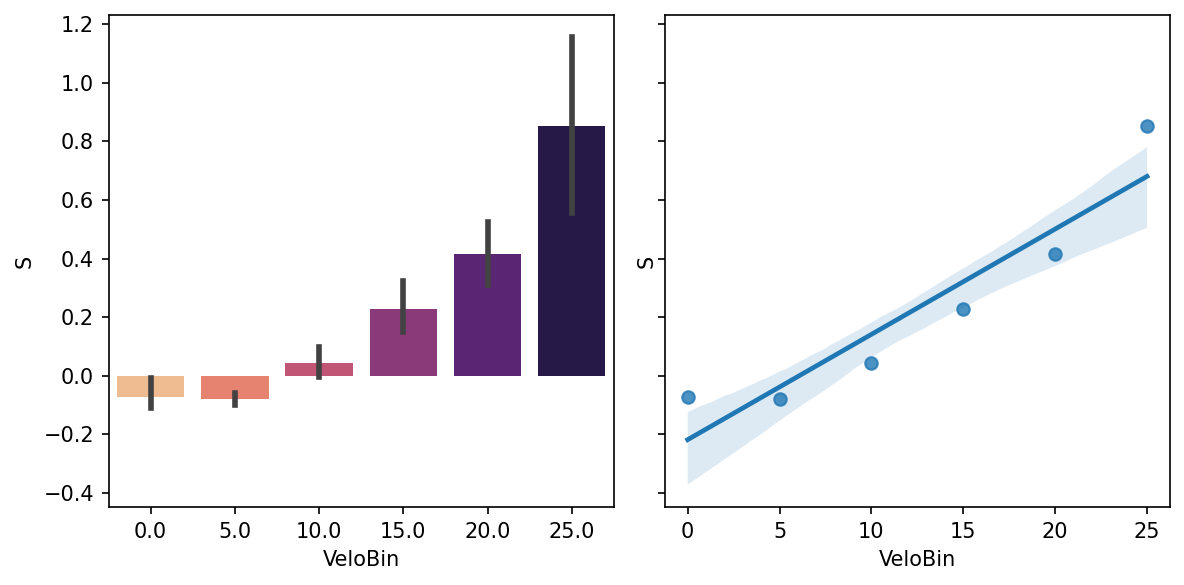

In [9]:
velobinned = df_to_plot.groupby('VeloBin').mean().reset_index()
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
sns.barplot(data=df_to_plot, x='VeloBin', y='S', ax=axs[0], palette='magma_r')
sns.regplot(data=velobinned, x='VeloBin', y='S', ax=axs[1], ci=68)
print(linregress(velobinned.VeloBin.values, velobinned['S'].values))
fig.tight_layout()

# Figure 5E

(1000.0, 7280.0)

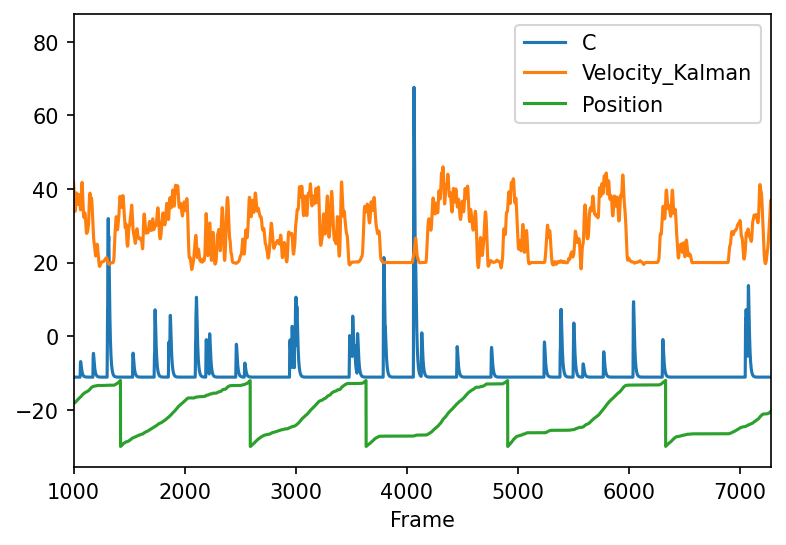

In [10]:
expID = 152
cell = 12

df_to_plot = behaviour.loc[expID]
df_to_plot['S'] = S_z[expID, cell]
df_to_plot['C'] = C_z[expID, cell]
df_to_plot['C'] = df_to_plot['C'] * 5 -10
df_to_plot['Position'] = df_to_plot['Position'] /20 - 30
df_to_plot['Velocity_Kalman'] = df_to_plot['Velocity_Kalman'].shift(3) * 5 +20
df_to_plot[['C', 'Velocity_Kalman', 'Position']].plot()
plt.xlim([1000, 7280])

# Figure 5F

LinregressResult(slope=-0.005691701209773675, intercept=0.0851252354991091, rvalue=-0.933668938889657, pvalue=0.0064537924800543035, stderr=0.0010916130518458479, intercept_stderr=0.016525113214792622)


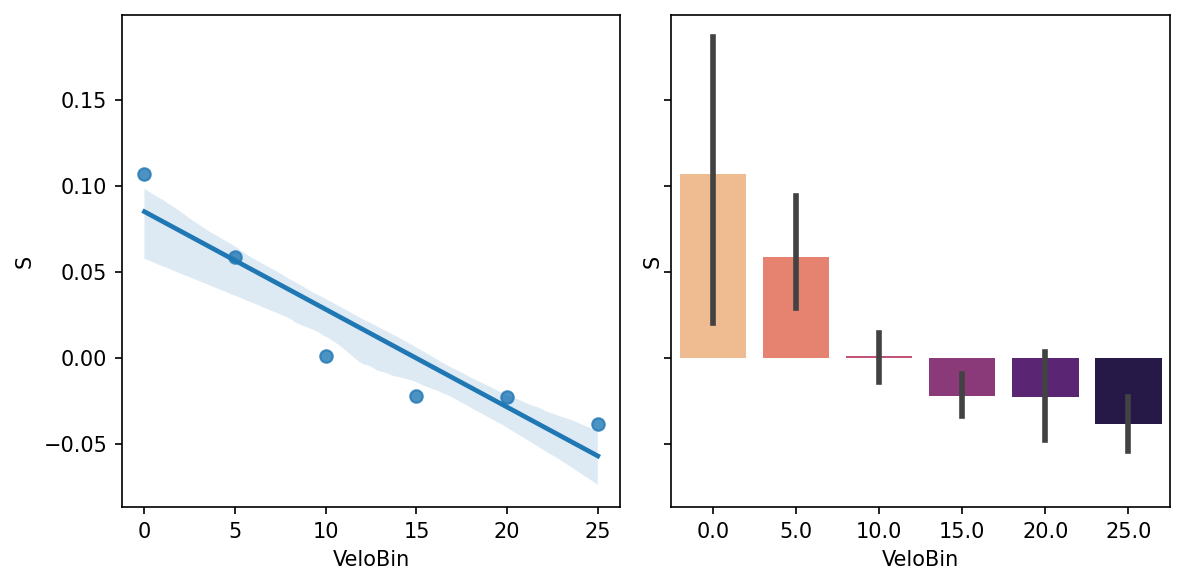

In [11]:
velobinned = df_to_plot.groupby('VeloBin').mean().reset_index()
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
sns.barplot(data=df_to_plot, x='VeloBin', y='S', ax=axs[1], ci=68, palette='magma_r')
sns.regplot(data=velobinned, x='VeloBin', y='S', ax=axs[0], ci=68)
print(linregress(velobinned.VeloBin.values, velobinned['S'].values))
fig.tight_layout()

# Figure 5C

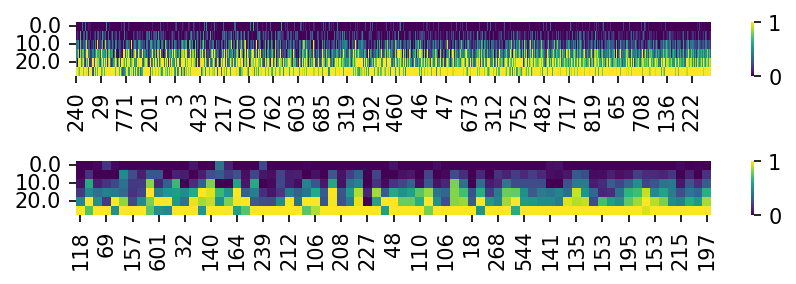

In [12]:
veloBinned.Red = veloBinned.Red.astype(bool)
fig, axs = plt.subplots(2,1, figsize=(6,2))
BinnedHeat = veloBinned.loc[(veloBinned.VeloCorrelationP_adj<.05)&(~veloBinned.Red)&(veloBinned.VeloCorrelation>0)].sort_values('VeloCorrelation').iloc[:, :6]
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat.T, cmap='viridis', ax=axs[0])
BinnedHeat = veloBinned.loc[(veloBinned.VeloCorrelationP_adj<.05)&(veloBinned.Red)&(veloBinned.VeloCorrelation>0)].sort_values('VeloCorrelation').iloc[:, :6]
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat.T, cmap='viridis', ax=axs[1])
fig.tight_layout()

# Figure 5G

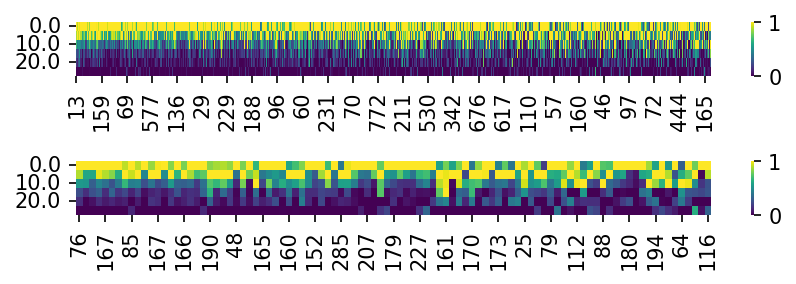

In [13]:
veloBinned.Red = veloBinned.Red.astype(bool)
fig, axs = plt.subplots(2,1, figsize=(6,2))
BinnedHeat = veloBinned.loc[(veloBinned.VeloCorrelationP_adj<.05)&(~veloBinned.Red)&(veloBinned.VeloCorrelation<0)].sort_values('VeloCorrelation').iloc[:, :6]
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat.T, cmap='viridis', ax=axs[0])
BinnedHeat = veloBinned.loc[(veloBinned.VeloCorrelationP_adj<.05)&(veloBinned.Red)&(veloBinned.VeloCorrelation<0)].sort_values('VeloCorrelation').iloc[:, :6]
BinnedHeat = BinnedHeat.sub(BinnedHeat.min(axis=1), axis=0)
BinnedHeat = BinnedHeat.div(BinnedHeat.max(axis=1), axis=0)
sns.heatmap(BinnedHeat.T, cmap='viridis', ax=axs[1])
fig.tight_layout()

# Figure S6C-D

In [14]:
behaviour.loc[(behaviour.Velocity_ds<2), 'VeloBin'] = -5

In [15]:
exps = [100, 103, 117, 125, 126, 127, 136, 137, 139, 140, 142, 143, 144, 148, 152, 154, 156, 163, 166]

veloBinned2 = []
for expID in exps:
    comps_exp = comps.loc[expID]
    comps_exp['ExpID'] = expID
    veloBinned2.append(S[expID].dropna().join(behaviour.loc[expID, 'VeloBin']).groupby('VeloBin').mean(
        ).drop(['PositionBin', 'Lap'], axis=1).T.join(comps_exp.reset_index()[[
            'ExpID', 'NeuronID', 'Red', 'VeloCorrelationP_adj', 'VeloCorrelation']]))
veloBinned2 = pd.concat(veloBinned2)
veloBinned2['maxVeloBin'] = veloBinned2.iloc[:, :7].idxmax(axis=1)
veloBinned2

,-5.0,0.0,5.0,10.0,15.0,20.0,25.0,ExpID,NeuronID,Red,VeloCorrelationP_adj,VeloCorrelation,maxVeloBin
0,0.004854,0.003817,0.006067,0.003650,0.004905,0.004878,0.000871,100,0,False,0.977643,-0.011470,5.0
1,0.000364,0.000000,0.000462,0.000000,0.000000,0.000000,0.000000,100,1,False,0.372179,-0.226335,5.0
2,0.000000,0.000000,0.000000,0.001621,0.000021,0.000458,0.000000,100,2,False,0.740870,-0.095840,10.0
3,0.000000,0.000000,0.000000,0.001621,0.000000,0.000178,0.002998,100,3,False,0.397640,0.215721,25.0
4,0.000223,0.002224,0.002066,0.000000,0.000000,0.000000,0.000000,100,4,False,0.100677,-0.388128,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,0.000000,0.000000,0.008660,0.004630,0.000927,0.000890,0.000363,166,918,False,0.104076,-0.384738,5.0
919,0.000070,0.000804,0.002180,0.001097,0.001483,0.001838,0.001464,166,919,False,0.922996,0.031838,5.0
920,0.000000,0.002163,0.001277,0.002150,0.000457,0.000000,0.000000,166,920,False,0.067210,-0.427842,0.0
921,0.000000,0.002518,0.000642,0.001665,0.000489,0.000000,0.000000,166,921,False,0.039354,-0.472598,0.0


Text(0.5, 1.0, 'Speed-negative')

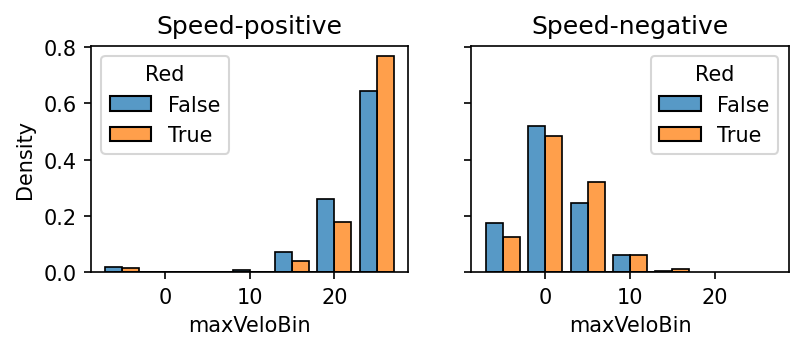

In [16]:
fig, axs = plt.subplots(1,2, figsize=(6,2), sharex=True, sharey=True)

sns.histplot(data=veloBinned2.loc[(veloBinned2.VeloCorrelationP_adj<.05)&(
    veloBinned2.VeloCorrelation>0)].reset_index(), x='maxVeloBin', hue='Red', 
    stat='density', common_norm=False, multiple='dodge', ax=axs[0], discrete=True, shrink=4,
    bins=veloBinned2.columns[:7])
axs[0].set_title('Speed-positive')

sns.histplot(data=veloBinned2.loc[(veloBinned2.VeloCorrelationP_adj<.05)&(
    veloBinned2.VeloCorrelation<0)].reset_index(), x='maxVeloBin', hue='Red', 
    stat='density', common_norm=False, multiple='dodge', ax=axs[1], discrete=True, shrink=4,
    bins=veloBinned2.columns[:7])
axs[1].set_title('Speed-negative')

In [17]:
pg.chi2_independence(veloBinned2.loc[(veloBinned2.VeloCorrelationP_adj<.05)&(
    veloBinned2.VeloCorrelation<0)].reset_index(), x='maxVeloBin',y='Red')

(Red              False       True
 maxVeloBin                       
 -5.0        123.638554  16.361446
  0.0        377.097590  49.902410
  5.0        185.457831  24.542169
  10.0        44.156627   5.843373
  15.0         2.649398   0.350602,
 Red         False  True
 maxVeloBin             
 -5.0          128    12
  0.0          380    47
  5.0          179    31
  10.0          44     6
  15.0           2     1,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  4.798521  4.0  0.308602  0.076035  0.380962
 1        cressie-read  0.666667  4.634834  4.0  0.326858  0.074727  0.368536
 2      log-likelihood  0.000000  4.399821  4.0  0.354592  0.072808  0.350630
 3       freeman-tukey -0.500000  4.284941  4.0  0.368815  0.071851  0.341858
 4  mod-log-likelihood -1.000000  4.209856  4.0  0.378349  0.071219  0.336120
 5              neyman -2.000000  4.150677  4.0  0.385998  0.070716  0.331596)

In [18]:
pg.chi2_independence(veloBinned2.loc[(veloBinned2.VeloCorrelationP_adj<.05)&(
    veloBinned2.VeloCorrelation>0)].reset_index(), x='maxVeloBin',y='Red')

(Red              False       True
 maxVeloBin                       
 -5.0         11.724462   1.275538
  10.0         4.509409   0.490591
  15.0        45.094086   4.905914
  20.0       169.553763  18.446237
  25.0       440.118280  47.881720,
 Red         False  True
 maxVeloBin             
 -5.0           12     1
  10.0           5     0
  15.0          47     3
  20.0         175    13
  25.0         432    56,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  4.740075  4.0  0.315022  0.079819  0.376530
 1        cressie-read  0.666667  4.909711  4.0  0.296688  0.081235  0.389375
 2      log-likelihood  0.000000  5.466981  4.0  0.242647  0.085721  0.431102
 3       freeman-tukey -0.500000       NaN  4.0       NaN       NaN       NaN
 4  mod-log-likelihood -1.000000       inf  4.0  0.000000       inf  1.000000
 5              neyman -2.000000       NaN  4.0       NaN       NaN       NaN)

# Figure 5D+H, S6A-B

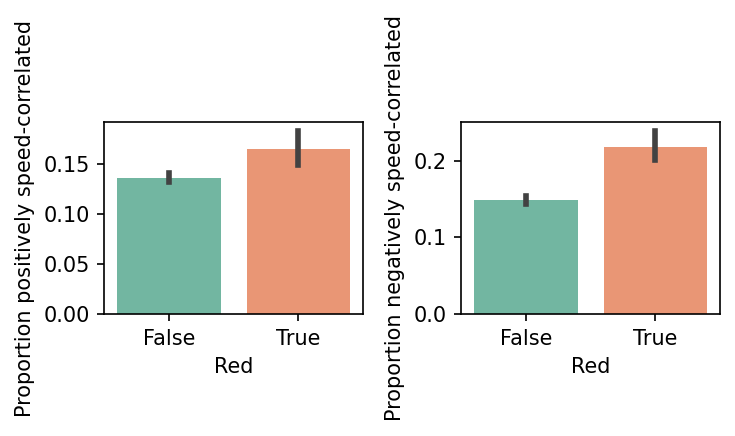

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5,2), sharey=False)
sns.barplot(data=comps, y='SpeedCell_p', x='Red', palette='Set2', ax=axs[0], ci=68)
axs[0].set_ylabel('Proportion positively speed-correlated')
sns.barplot(data=comps, y='SpeedCell_n', x='Red', palette='Set2', ax=axs[1], ci=68)
axs[1].set_ylabel('Proportion negatively speed-correlated')
fig.tight_layout()

## Figure 5D stats

In [20]:
pg.chi2_independence(comps, x='SpeedCell_p', y='Red')

(Red                False        True
 SpeedCell_p                         
 False        4245.492182  382.507818
 True          682.507818   61.492182,
 Red           False   True
 SpeedCell_p               
 False        4256.5  371.5
 True          671.5   72.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  2.493392  1.0  0.114325  0.021544  0.351834
 1        cressie-read  0.666667  2.457693  1.0  0.116950  0.021389  0.347642
 2      log-likelihood  0.000000  2.389344  1.0  0.122165  0.021090  0.339587
 3       freeman-tukey -0.500000  2.340621  1.0  0.126039  0.020874  0.333819
 4  mod-log-likelihood -1.000000  2.293958  1.0  0.129878  0.020664  0.328278
 5              neyman -2.000000  2.206426  1.0  0.137437  0.020266  0.317836)

In [21]:
speedcells_red_mouse = pd.DataFrame(comps.groupby(['Mouse', 'Red']).mean()['SpeedCell_p']).pivot_table(index='Red', columns='Mouse')
speedcells_red_mouse.drop(speedcells_red_mouse.columns[1], axis=1, inplace=True)
speedcells_red_mouse

SpeedCell_p                                        
Mouse       207.0     209.0     210.0     211.0     212.0
Red                                                      
False    0.154589  0.083333  0.139156  0.127476  0.178862
True     0.171429  0.000000  0.000000  0.176301  0.000000

In [22]:
chi2_contingency(speedcells_red_mouse.T)

(0.3364426005160728,
 0.9873418327523446,
 4,
 array([[0.21607618, 0.10994176],
        [0.05523116, 0.02810218],
        [0.09222888, 0.04692699],
        [0.2013351 , 0.10244135],
        [0.11854492, 0.06031687]]))

In [23]:
comps['SpeedCell_p0'] = comps['SpeedCell_p'].astype(int)
speedcells_p = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='SpeedCell_p0', resamples=5000, proportional=True)
speedcells_p.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4928,444,Cohen's h,None,0.079144,95,-0.012861,0.179781,0.0934,0.122722,-1.545995,0.098821,-1.650883,0.098822,1063106.0


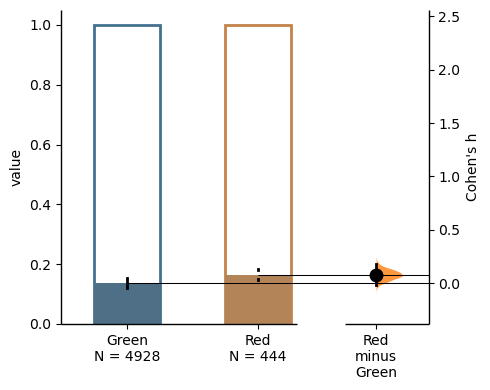

In [24]:
speedcells_p.cohens_h.plot();

## Figure 5H stats

In [25]:
pg.chi2_independence(comps, x='SpeedCell_n',y='Red')

(Red                False        True
 SpeedCell_n                         
 False        4166.600149  375.399851
 True          761.399851   68.600149,
 Red           False   True
 SpeedCell_n               
 False        4194.5  347.5
 True          733.5   96.5,
                  test    lambda       chi2  dof      pval    cramer     power
 0             pearson  1.000000  14.629615  1.0  0.000131  0.052185  0.968903
 1        cressie-read  0.666667  14.197203  1.0  0.000165  0.051408  0.964693
 2      log-likelihood  0.000000  13.409568  1.0  0.000250  0.049962  0.955617
 3       freeman-tukey -0.500000  12.879799  1.0  0.000332  0.048965  0.948331
 4  mod-log-likelihood -1.000000  12.396687  1.0  0.000430  0.048038  0.940730
 5              neyman -2.000000  11.553136  1.0  0.000676  0.046375  0.924929)

In [26]:
speedcellsn_red_mouse = pd.DataFrame(comps.groupby(['Mouse', 'Red']).mean()['SpeedCell_n']).pivot_table(index='Red', columns='Mouse')
speedcellsn_red_mouse

SpeedCell_n                                              
Mouse       207.0     208.0 209.0     210.0     211.0     212.0
Red                                                            
False    0.128019  0.352941  0.25  0.106979  0.200609  0.162602
True     0.142857  0.000000  0.00  0.045455  0.245665  0.333333

In [27]:
chi2_contingency(speedcellsn_red_mouse.T)

(0.6267378732500666,
 0.9867463322961185,
 5,
 array([[0.16528826, 0.1055882 ],
        [0.21536398, 0.1375772 ],
        [0.15254949, 0.09745051],
        [0.09301445, 0.05941879],
        [0.27231559, 0.17395859],
        [0.30261849, 0.19331647]]))

In [28]:
comps['SpeedCell_n0'] = comps['SpeedCell_n'].astype(int)
speedcells_n = dabest.load(comps, idx=("Green", "Red"), x='RedC', y='SpeedCell_n0', resamples=5000, proportional=True)
speedcells_n.cohens_h.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,Green,Red,4928,444,Cohen's h,None,0.180839,95,0.081383,0.277171,0.0004,0.000633,-3.438872,0.000098,-3.898193,0.000099,1017734.0


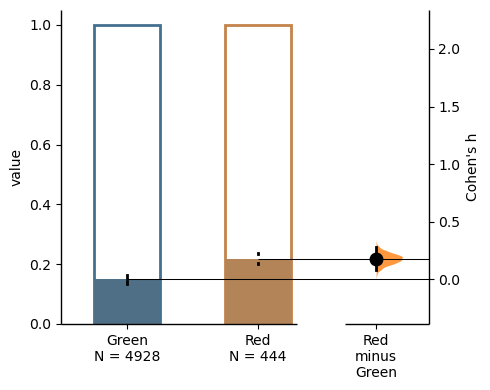

In [29]:
speedcells_n.cohens_h.plot();